In [118]:
import warnings
warnings.filterwarnings("ignore") 
from IPython.core.display import display, HTML

import time

import numpy as np
from numpy import matlib

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
from scipy.sparse import csgraph
import scipy

Explorando dados

(5000, 2)


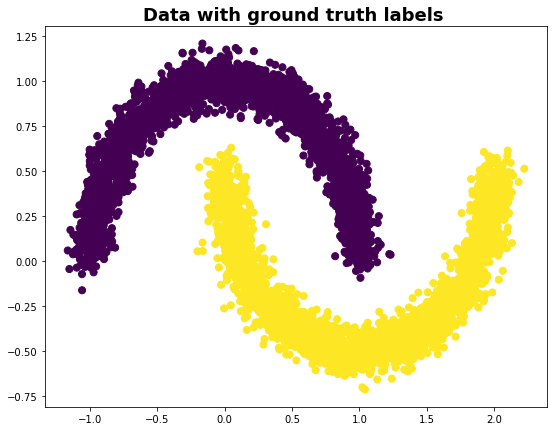

In [2]:
random_state = 21
X_mn, y_mn = make_moons(5000, noise=.07, random_state=random_state)
print(X_mn.shape)
cmap = 'viridis'
dot_size=50

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Data with ground truth labels ', fontsize=18, fontweight='demi')

ax.scatter(X_mn[:, 0], X_mn[:, 1],c=y_mn,s=dot_size, cmap=cmap)

## Passo 1
### Hybrid Representative Selection

In [3]:
def getRepresentivesByRandomSelection(data, pSize):
    N = data.shape[0]
    if pSize > N:
        pSize = N
    
    selectIdx = np.random.permutation(np.arange(N))[:pSize]
    randSelect = []
    for i in selectIdx:
        randSelect.append(data[i,:])

    return np.array(randSelect)

def getRepresentativesByHybridSelection(data, pSize, cntTimes=10):
    N = data.shape[0]
    bigPSize = cntTimes * pSize
    
    if pSize > N: 
        pSize = N
    if bigPSize > N: 
        bigPSize = N

    #random selection
    np.random.seed(int(time.time()))
    RpBigPdata = getRepresentivesByRandomSelection(data, bigPSize)
    
    #KNN selection
    RpData = KMeans(n_clusters=pSize, max_iter=cntTimes).fit(RpBigPdata)
    
    return RpData

RpData = getRepresentativesByHybridSelection(X_mn, 1000, 300)

In [4]:
RpData.cluster_centers_

array([[ 0.37094208, -0.26281599],
       [ 0.97102196,  0.45934643],
       [-0.3702694 ,  0.8453367 ],
       ...,
       [-0.78428369,  0.61744117],
       [-0.09834678,  0.89908994],
       [ 0.1338368 ,  0.9706153 ]])

## Passo 2
### Approximation of K-Nearest Representatives

In [5]:
cntRepCls = int(np.floor(np.sqrt(RpData.cluster_centers_.shape[0])))
print(cntRepCls)
AprData = KMeans(n_clusters=cntRepCls, max_iter=600).fit(RpData.cluster_centers_)

31


In [6]:
AprData.labels_.shape

(1000,)

In [7]:
AprData.cluster_centers_

array([[ 1.97189363,  0.31876693],
       [ 0.09865456,  0.99450443],
       [ 0.72677465, -0.44711118],
       [-0.84333216,  0.53258812],
       [ 0.91178058,  0.45082234],
       [ 1.57006519, -0.30942334],
       [ 0.0338211 ,  0.07059785],
       [ 0.77210524,  0.64037726],
       [ 1.19131737, -0.46769031],
       [-1.00278195,  0.08205258],
       [-0.70741304,  0.72134736],
       [-0.51698099,  0.85433037],
       [ 0.20608669, -0.27319757],
       [ 0.34102253,  0.94321269],
       [ 0.95730887, -0.51868246],
       [-0.03032075,  0.48267312],
       [ 1.01253045,  0.04911147],
       [ 1.71370888, -0.15870057],
       [-0.93495238,  0.31352622],
       [-0.32621183,  0.96052234],
       [ 0.06789564,  0.2936277 ],
       [ 1.91452247,  0.11597694],
       [ 1.41150084, -0.43222316],
       [ 0.42356178, -0.23443888],
       [ 0.20595529, -0.06069282],
       [ 0.57406293,  0.8317412 ],
       [ 0.50403488, -0.40409472],
       [-0.11893582,  0.99119015],
       [ 0.97940471,

In [8]:
N = X_mn.shape[0]
p = AprData.cluster_centers_.shape[0]

centerDist = np.zeros((N, p))
for i in range(centerDist.shape[0]):
    for j in range(centerDist.shape[1]):
        centerDist[i,j] = np.linalg.norm(X_mn[i]-AprData.cluster_centers_[j])

In [9]:
minCenterIdxs = np.argmin(centerDist, axis=1)
cntRepCls = AprData.cluster_centers_.shape[0]
# minCenterIdxs
minCenterIdxs.shape

(5000,)

In [10]:
'''distances = np.zeros((N, 1))
for i in range(N):
    cluster_v = minCenterIdxs[i]
    centroid_v = AprData.cluster_centers_[cluster_v]

    feature = np.expand_dims(X_mn[i], 0) 

    cluster_b = RpData.predict(feature)
    centroid_b = RpData.cluster_centers_[cluster_b]

    #Distancia da feature até o bloco principal, distancia do centroide até o bloco principal
    distances[i] = min([np.linalg.norm(feature-centroid_v), np.linalg.norm(centroid_b-centroid_v)])

distances
'''

'distances = np.zeros((N, 1))\nfor i in range(N):\n    cluster_v = minCenterIdxs[i]\n    centroid_v = AprData.cluster_centers_[cluster_v]\n\n    feature = np.expand_dims(X_mn[i], 0) \n\n    cluster_b = RpData.predict(feature)\n    centroid_b = RpData.cluster_centers_[cluster_b]\n\n    #Distancia da feature até o bloco principal, distancia do centroide até o bloco principal\n    distances[i] = min([np.linalg.norm(feature-centroid_v), np.linalg.norm(centroid_b-centroid_v)])\n\ndistances\n'

In [47]:
nearestRepInRpFeaIdx = np.zeros((N), dtype=np.int32)
for i in range(p):
    originalIdxs = np.where(minCenterIdxs == i)[0]
    aprDataIdxs = np.where(AprData.labels_ == i)[0]

    originalTemp = np.take(X_mn, originalIdxs).ravel()
    aprDataTemp = np.take(RpData.cluster_centers_, aprDataIdxs).ravel()

    temp = np.zeros((originalTemp.shape[0], aprDataTemp.shape[0]))

    for j in range(temp.shape[0]):
        for k in range(temp.shape[1]):
            temp[j, k] = np.linalg.norm(originalTemp[j]-aprDataTemp[k])

    tempMin = np.argmin(temp, axis=1)

    for j in range(temp.shape[0]):
        nearestRepInRpFeaIdx[originalIdxs[j]] = int(aprDataIdxs[tempMin[j]])

In [97]:
Knn = 5
neighSize = 10*Knn
RpFeaW = np.zeros((RpData.cluster_centers_.shape[0],RpData.cluster_centers_.shape[0]))

for j in range(RpFeaW.shape[0]):
        for k in range(RpFeaW.shape[1]):
            RpFeaW[j, k] = np.linalg.norm(RpData.cluster_centers_[j]-RpData.cluster_centers_[k])

RpFeaKnnIdx = np.argsort(RpFeaW, axis=1, kind='mergesort')

RpFeaKnnIdx = RpFeaKnnIdx[:,:int(neighSize)]
RpFeaKnnDist = np.zeros((N,RpFeaKnnIdx.shape[1]));

#print(RpFeaKnnDist.shape)
#print(nearestRepInRpFeaIdx.shape)
for i in range(RpData.cluster_centers_.shape[0]):
    
    originalIdxs = np.where(nearestRepInRpFeaIdx == i)[0]
    originalTemp = np.take(X_mn, originalIdxs).ravel()
    #print(originalIdxs)
    #RpFea(RpFeaKnnIdx(i,:),:)
    RpFeatTemp = np.take(RpData.cluster_centers_, RpFeaKnnIdx[i]).ravel()
    
    temp = np.ones((originalTemp.shape[0], RpFeatTemp.shape[0]))

    for j in range(temp.shape[0]):
        for k in range(temp.shape[1]):
            temp[j, k] = np.linalg.norm(originalTemp[j]-RpFeatTemp[k])
    
    for j in range(temp.shape[0]):
        RpFeaKnnDist[originalIdxs[j], :] = temp[j]

RpFeaKnnDist

array([[0.03143313, 0.32571336, 0.59069324, ..., 0.42342389, 0.38329011,
        0.03903476],
       [0.01401447, 0.34767724, 0.61817175, ..., 0.77613224, 0.14800216,
        0.61659208],
       [0.019935  , 0.10433575, 1.66867708, ..., 0.28337034, 0.93900246,
        1.52895284],
       ...,
       [0.0813747 , 0.52558332, 0.77027867, ..., 0.65456959, 1.80342864,
        1.20179215],
       [0.00215306, 1.04406537, 0.57133408, ..., 0.17203112, 0.78274857,
        0.64500729],
       [0.01411122, 0.35998067, 0.1817218 , ..., 1.37268447, 0.3178228 ,
        0.27413566]])

In [98]:
RpFeaKnnIdxFull = RpFeaKnnIdx[nearestRepInRpFeaIdx,:];
print(RpFeaKnnIdxFull.shape)

(5000, 50)


In [99]:
knnDist = np.zeros((N,Knn));
knnIdx = np.zeros((N,Knn));

for i in range(Knn):
    idx = np.argmin(RpFeaKnnDist, axis=1)
    minV = np.amin(RpFeaKnnDist, axis=1)
    temp = ((idx)*N) + np.arange(N).T
    
    knnDist [:, i] = minV
    
    for j in range(len(temp)):
        
        knnIdx[j, i] = RpFeaKnnIdxFull[j, i]
        
        if(temp[j] < N):
            RpFeaKnnDist[j, i] = np.inf
            
print(RpFeaKnnDist)

[[       inf 0.32571336 0.59069324 ... 0.42342389 0.38329011 0.03903476]
 [       inf 0.34767724 0.61817175 ... 0.77613224 0.14800216 0.61659208]
 [       inf 0.10433575 1.66867708 ... 0.28337034 0.93900246 1.52895284]
 ...
 [       inf 0.52558332 0.77027867 ... 0.65456959 1.80342864 1.20179215]
 [       inf 1.04406537 0.57133408 ... 0.17203112 0.78274857 0.64500729]
 [       inf 0.35998067 0.1817218  ... 1.37268447 0.3178228  0.27413566]]


In [12]:
def GaussianKernel(x, y, sigma):
    return np.exp(-(np.power(np.linalg.norm(x-y),2))/2*np.power(sigma,2))
def GaussDistance(x, y, sigma=0.5):
    return np.sqrt(GaussianKernel(x, x, sigma) - 2*GaussianKernel(x, y, sigma) + GaussianKernel(y, y, sigma))

In [102]:
knnMeanDiff = np.mean(knnDist)
Gsdx = np.exp(-(np.power(knnDist,2))/2*np.power(knnMeanDiff,2))
print(Gsdx)

[[0.99999907 0.99999895 0.99999895 0.99999895 0.99999895]
 [0.99999981 0.99999753 0.99999753 0.99999753 0.99999753]
 [0.99999962 0.99999942 0.99999942 0.99999942 0.99999942]
 ...
 [0.99999373 0.99997758 0.99997758 0.99997758 0.99997758]
 [1.         0.99997199 0.99997199 0.99997199 0.99997199]
 [0.99999981 0.99999734 0.99999734 0.99999734 0.99999734]]


In [103]:
Gsdx[Gsdx == 0] = np.finfo(float).eps

In [117]:
Gidx = matlib.repmat(np.arange(N), Knn, 1).T
Gidx

array([[   0,    0,    0,    0,    0],
       [   1,    1,    1,    1,    1],
       [   2,    2,    2,    2,    2],
       ...,
       [4997, 4997, 4997, 4997, 4997],
       [4998, 4998, 4998, 4998, 4998],
       [4999, 4999, 4999, 4999, 4999]])

In [119]:
def sparse(i, j, v, m, n):
    """
    Create and compressing a matrix that have many zeros
    Parameters:
        i: 1-D array representing the index 1 values 
            Size n1
        j: 1-D array representing the index 2 values 
            Size n1
        v: 1-D array representing the values 
            Size n1
        m: integer representing x size of the matrix >= n1
        n: integer representing y size of the matrix >= n1
    Returns:
        s: 2-D array
            Matrix full of zeros excepting values v at indexes i, j
    """
    return scipy.sparse.csr_matrix((v, (i, j)), shape=(m, n))

In [132]:
p = RpData.cluster_centers_.shape[0]

B = sparse(Gidx.ravel(), knnIdx.ravel(), Gsdx.ravel(), N, p).toarray()


## Passo 3
### Bipartite Graph Partitioning

In [143]:
B

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [144]:
dx = np.sum(B, 1)
dx = np.where(dx == 0, 1e-10, dx)
dx = 1/dx
Dx = np.zeros((N, N))
np.fill_diagonal(Dx, dx)
Er = B.T @ Dx @ B

In [145]:
d = np.sum(Er, 1);
d = 1/np.sqrt(d)
D = np.zeros((p, p))
np.fill_diagonal(D, d)
Dr = D @ Er @ D
Dr = (Dr + Dr.T)/2

In [146]:
aval, avec = np.linalg.eig(Dr)

In [147]:
idx = np.argsort(aval, kind='mergesort')[::-1]
Ncut_avec = D @ avec[:,idx[:]]

In [148]:
res = Dx @ B @ Ncut_avec

In [149]:
res.shape

(5000, 1000)

In [156]:
norm = (np.sqrt(np.sum(res*res,1)) + 1e-10)
for i in range(res.shape[0]):
    res[i,:] = res[i,:]/norm[i]

In [157]:
res.real

array([[ 2.06913509e-04, -1.28264203e-01, -1.48417179e-01, ...,
        -9.91187733e-13, -3.52062270e-13,  1.52082840e-12],
       [ 9.45967624e-02, -5.59712087e-16,  3.90099961e-16, ...,
         1.08228296e-11,  8.36326080e-12, -4.30909851e-12],
       [ 1.53936463e-04, -9.54241113e-02,  6.79594570e-02, ...,
        -6.62444273e-14,  9.67367844e-14,  1.57510325e-13],
       ...,
       [ 1.09095541e-01, -4.83738432e-16,  7.82262730e-16, ...,
        -4.74737666e-12, -5.28941700e-12, -6.74703224e-12],
       [ 9.99203098e-02, -6.23982769e-16,  3.06135742e-16, ...,
         2.40285671e-12,  1.31445504e-12,  1.41458262e-13],
       [ 1.14348853e-01, -6.31906632e-16,  1.00123617e-15, ...,
         3.69467107e-12,  1.41470910e-11, -2.15830653e-11]])

In [158]:
K =  KMeans(n_clusters=2, max_iter=1000).fit(res.real)

In [159]:
pred = K.labels_

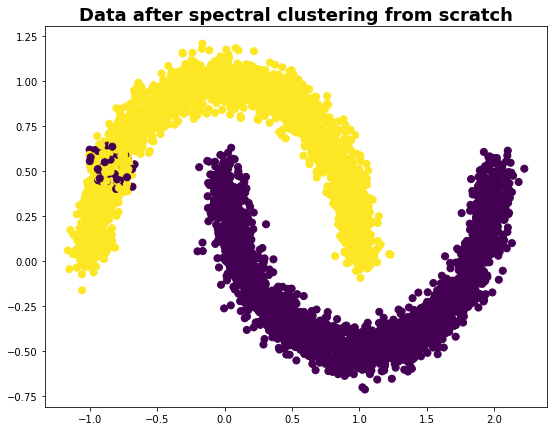

In [160]:
fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Data after spectral clustering from scratch', fontsize=18, fontweight='demi')
ax.scatter(X_mn[:, 0], X_mn[:, 1],c=pred,s=dot_size, cmap=cmap)